In [17]:
import polars as pl;
import csv;

Carga de datos desde Drive

In [18]:

from google.colab import drive, files

drive.mount('/content/drive')
log_file_path = '/content/drive/My Drive/Colab_Folder/access.log'
csv_file_path = '/content/drive/My Drive/Colab_Folder/archivo.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Convierto el archivo .logs a .csv para poder trabajarlo con Polars

In [19]:
# Abro el archivo original .log
with open(log_file_path, 'r') as file:
    log_data = file.readlines()

# Los encabezados para el archivo .csv
headers = ["ip", "timestamp", "request_method", "url", "http_version", "status_code", "size", "user_agent"]

# Lo leo linea por linea y voy guardando la info en el archivo.csv
with open(csv_file_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(headers)

    for line in log_data:
        parts = line.split(' ')

        try:
            ip = parts[0]
            timestamp = ' '.join(parts[3:5]).strip('[]')
            request_method = parts[5].strip('"') if parts[5] != '"-"' else None
            url = parts[6] if len(parts) > 6 else None
            http_version = parts[7].strip('"') if len(parts) > 7 else None
            status_code = int(parts[8]) if len(parts) > 8 and parts[8].isdigit() else None
            size = int(parts[9]) if len(parts) > 9 and parts[9].isdigit() else None
            user_agent = ' '.join(parts[11:]).strip('"') if len(parts) > 11 else None

            csvwriter.writerow([ip, timestamp, request_method, url, http_version, status_code, size, user_agent])

        except (IndexError, ValueError) as e:
            print(f"Error procesando la línea: {line.strip()} - Error: {e}")
            csvwriter.writerow([ip, timestamp, None, None, None, None, None, None])

## Funciones Auxiliares

#### **filtrar_map_server:**
MapServer es una plataforma de código abierto para publicar datos espaciales y aplicaciones interactivas de mapeo en la web.
libcurl es una biblioteca utilizada por MapServer para manejar transferencias de datos a través de varios protocolos de red.

---

#### **filtar_wms:**
Un WMS (Web Map Service) es un estándar desarrollado por el OGC (Open Geospatial Consortium) que permite la visualización de mapas georreferenciados a través de la web. Un servicio WMS puede devolver imágenes de mapas basadas en datos geográficos, y el documento de capacidades describe cómo se pueden solicitar estas imágenes y qué capas están disponibles.

Dado que todas las solicitudes son muy cercanas en tiempo y provienen de la misma ip, se podría decir que: Un usuario hizo varias solicitudes consecutivas rápidamente. O, lo que es más probable, un script o un programa hizo esas solicitudes.

---

#### **filtrar_jcemediabox:**
Estas URLs están asociadas con JCEMediaBox, un plugin de Joomla que facilita la incorporación de lightboxes para mostrar imágenes, vídeos y otros tipos de medios de una manera atractiva y funcional. Los archivos .js contienen el código JavaScript necesario para hacer funcionar el lightbox, mientras que los archivos .css contienen los estilos que determinan la apariencia del lightbox en la página web.

---

#### **filtrar_css y filtrar_js:**
El objetivo de nuestro análisis es entender el tráfico relacionado con la funcionalidad del sitio y excluir contenido estático como .css y .js. Por lo que decidimos filtrar estos archivos. Si quisiéramos hacer un análisis más completo del tráfico, deberíamos mantener estos archivos.

Pero los archivos .css y .js son muy frecuentes en los logs y filtrarlos puede reducir el "ruido" en los datos, permitiéndonos enfocarnos en las solicitudes más relevantes.


In [20]:
# Funciones auxiliares - Limpieza de datos
def filtrar_googlebot(df):
    return df.filter(~pl.col("user_agent").str.contains('Googlebot'))

def filtrar_baiduspider(df):
    return df.filter(~pl.col("user_agent").str.contains('Baiduspider'))

def filtrar_agesic_crawler(df):
    return df.filter(~pl.col("user_agent").str.contains('agesic-crawler'))

def filtrar_robots_y_crawlers(df):
    df = filtrar_googlebot(df)
    df = filtrar_baiduspider(df)
    df = filtrar_agesic_crawler(df)
    return df

def filtrar_map_server(df):
    return df.filter(~pl.col("url").str.contains('/wfsPCN1000.cgi'))

def filtrar_wms(df):
    return df.filter(~pl.col("url").str.contains('SERVICE=WMS'))

def filtrar_solicitudes_servicios_mapas(df):
    df = filtrar_map_server(df)
    df = filtrar_wms(df)
    return df

def filtar_jcemediabox(df):
    return df.filter(~pl.col("url").str.contains('/plugins/system/jcemediabox/'))

def filtrar_css(df):
    regex = r'\.css$'
    return df.filter(~pl.col("url").str.contains(regex))

def filtrar_js(df):
    regex = r'\.js$'
    return df.filter(~pl.col("url").str.contains(regex))

def filtrar_png(df):
    regex = r'\.png$'
    return df.filter(~pl.col("url").str.contains(regex))

def filtrar_jpg(df):
    regex = r'\.jpg$'
    return df.filter(~pl.col("url").str.contains(regex))

def filtrar_gif(df):
    regex = r'\.gif$'
    return df.filter(~pl.col("url").str.contains(r'\.gif$'))

def filtrar_favicon(df):
    regex = r'favicon\.ico$'
    return df.filter(~pl.col("url").str.contains(r'favicon\.ico$'))

def filtrar_datos(df):
    df = filtrar_robots_y_crawlers(df)
    df = filtrar_solicitudes_servicios_mapas(df)
    df = filtar_jcemediabox(df)
    df = filtrar_css(df)
    df = filtrar_js(df)
    df = filtrar_png(df)
    df = filtrar_jpg(df)
    df = filtrar_gif(df)
    df = filtrar_favicon(df)
    return df

def formatear_fecha(df):
    return df.with_columns([pl.col("timestamp").str.strptime(pl.Datetime, "%d/%b/%Y:%H:%M:%S %z", strict=False).alias("timestamp")])

# Funciones auxiliares - Páginas más visitadas

def filtrar_URLs_vacias(df):
    return df.filter(pl.col("url").is_not_null())

def count_frecuencia_url(df):
    return df.group_by("url").agg(pl.col("url").count().alias("visit_count"))


## Main

In [21]:
df = pl.read_csv(csv_file_path)

#### Reconocimiento del data frame
Veamos cómo está compuesto el dataframe

In [22]:
df.schema

OrderedDict([('ip', Utf8),
             ('timestamp', Utf8),
             ('request_method', Utf8),
             ('url', Utf8),
             ('http_version', Utf8),
             ('status_code', Int64),
             ('size', Int64),
             ('user_agent', Utf8)])

Mostramos las primeras 5 filas del dataframe

In [23]:
df.head(5)

ip,timestamp,request_method,url,http_version,status_code,size,user_agent
str,str,str,str,str,i64,i64,str
"""127.0.0.1""","""02/Jun/2013:06…","""OPTIONS""","""*""","""HTTP/1.0""",200,167,"""Apache/2.2.14 …"
"""127.0.0.1""","""02/Jun/2013:06…","""OPTIONS""","""*""","""HTTP/1.0""",200,167,"""Apache/2.2.14 …"
"""127.0.0.1""","""02/Jun/2013:06…","""OPTIONS""","""*""","""HTTP/1.0""",200,167,"""Apache/2.2.14 …"
"""180.76.5.150""","""02/Jun/2013:06…","""GET""","""/index.php/com…","""HTTP/1.1""",200,8842,"""Mozilla/5.0 (c…"
"""190.64.2.162""","""02/Jun/2013:06…","""GET""","""/robots.txt""","""HTTP/1.0""",200,718,"""agesic-crawler…"


Veremos con que cantidad de valores vacíos nos encontramos en el df

In [24]:
cantidad_nulos = df.null_count()
cantidad_nulos

ip,timestamp,request_method,url,http_version,status_code,size,user_agent
u32,u32,u32,u32,u32,u32,u32,u32
0,0,463,0,0,464,464,464


#### Limpieza de nulos
Vemos que hay una gran cantidad de celdas con valores en nulo, por lo que vamos a filtrar las filas que tienen valores vacíos en al menos una columna para poder visualizar algunos casos

In [25]:
from functools import reduce

mask = reduce(lambda a, b: a | b, [df[col].is_null() for col in df.columns])
rows_con_nulos = df.filter(mask)
rows_con_nulos.head(10)

ip,timestamp,request_method,url,http_version,status_code,size,user_agent
str,str,str,str,str,i64,i64,str
"""186.49.154.44""","""02/Jun/2013:16…",null,"""408""","""0""",null,null,null
"""66.249.82.10""","""02/Jun/2013:16…",null,"""408""","""0""",null,null,null
"""186.49.154.44""","""02/Jun/2013:16…",null,"""408""","""0""",null,null,null
"""186.49.13.241""","""02/Jun/2013:17…",null,"""408""","""0""",null,null,null
"""190.233.189.16…","""02/Jun/2013:17…",null,"""408""","""0""",null,null,null
"""190.233.189.16…","""02/Jun/2013:17…",null,"""408""","""0""",null,null,null
"""186.54.145.192…","""02/Jun/2013:18…",null,"""408""","""0""",null,null,null
"""186.54.145.192…","""02/Jun/2013:18…",null,"""408""","""0""",null,null,null
"""186.54.145.192…","""02/Jun/2013:18…",null,"""408""","""0""",null,null,null


Encontramos algo que nos llama la atención y es que están apareciendo algunos status code dentro de la columna de urls, lo podemos verificar con la siguiente consulta:

In [26]:
unique_status = df.select("url").unique()
print(unique_status.sort("url", descending=True))

shape: (28_677, 1)
┌───────────────────────────────────┐
│ url                               │
│ ---                               │
│ str                               │
╞═══════════════════════════════════╡
│ http://www.sina.com.cn/           │
│ 408                               │
│ 200                               │
│ /wp-content/themes/Bold/timthumb… │
│ …                                 │
│ //admin/tting.php                 │
│ /%7Bphocagallery%20view=category… │
│ /                                 │
│ *                                 │
└───────────────────────────────────┘


Vamos a filtrar las filas que contienen códigos de estado en la columna `url` para que que valores tienen esas filas

In [27]:
status_codes = ["200","408"]
urls_with_status_codes = df.filter(pl.col("url").is_in(status_codes))

print(urls_with_status_codes)

shape: (464, 8)
┌──────────────┬──────────────┬──────────────┬─────┬─────────────┬─────────────┬──────┬────────────┐
│ ip           ┆ timestamp    ┆ request_meth ┆ url ┆ http_versio ┆ status_code ┆ size ┆ user_agent │
│ ---          ┆ ---          ┆ od           ┆ --- ┆ n           ┆ ---         ┆ ---  ┆ ---        │
│ str          ┆ str          ┆ ---          ┆ str ┆ ---         ┆ i64         ┆ i64  ┆ str        │
│              ┆              ┆ str          ┆     ┆ str         ┆             ┆      ┆            │
╞══════════════╪══════════════╪══════════════╪═════╪═════════════╪═════════════╪══════╪════════════╡
│ 186.49.154.4 ┆ 02/Jun/2013: ┆ null         ┆ 408 ┆ 0           ┆ null        ┆ null ┆ null       │
│ 4            ┆ 16:24:20     ┆              ┆     ┆             ┆             ┆      ┆            │
│              ┆ -0300        ┆              ┆     ┆             ┆             ┆      ┆            │
│ 66.249.82.10 ┆ 02/Jun/2013: ┆ null         ┆ 408 ┆ 0           ┆ null    

Investigando los casos null en profundidad nos encontramos con que son casos borde. Los de status 200 son casos con datos no legibles o anómalos y los de status 408 parecen ser una solicitud incompleta o malformada debido a un timeout en la solicitud, problemas de parte del cliente o error de red o conexión.

Este tipo de entradas en los logs a menudo se descartan en análisis de tráfico web ya que no proporcionan datos útiles sobre las solicitudes válidas. Sin embargo, pueden ser útiles para detectar problemas de red o errores en los clientes.

Por lo que vamos a filtrar las filas donde la columna `url` contenga los valores `200` o `408`

In [28]:
df_sin_nulos = df.filter(
    ~pl.col("url").str.contains('200') & ~pl.col("url").str.contains('408')
)

print(df_sin_nulos)
df_sin_nulos.write_csv("log_sin_nulos.csv")

shape: (203_725, 8)
┌─────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬──────┬────────────┐
│ ip          ┆ timestamp  ┆ request_me ┆ url        ┆ http_versi ┆ status_cod ┆ size ┆ user_agent │
│ ---         ┆ ---        ┆ thod       ┆ ---        ┆ on         ┆ e          ┆ ---  ┆ ---        │
│ str         ┆ str        ┆ ---        ┆ str        ┆ ---        ┆ ---        ┆ i64  ┆ str        │
│             ┆            ┆ str        ┆            ┆ str        ┆ i64        ┆      ┆            │
╞═════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪══════╪════════════╡
│ 127.0.0.1   ┆ 02/Jun/201 ┆ OPTIONS    ┆ *          ┆ HTTP/1.0   ┆ 200        ┆ 167  ┆ Apache/2.2 │
│             ┆ 3:06:48:17 ┆            ┆            ┆            ┆            ┆      ┆ .14        │
│             ┆ -0300      ┆            ┆            ┆            ┆            ┆      ┆ (Ubuntu)   │
│             ┆            ┆            ┆            ┆            ┆    

Verificamos que ya no hayan más casos de datos nulos

In [29]:
cantidad_nulos = df_sin_nulos.null_count()
cantidad_nulos

ip,timestamp,request_method,url,http_version,status_code,size,user_agent
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0


#### Limpieza de peticiones internas

Es común que el servidor web realice solicitudes internas a sí mismo para verificar su configuración, comprobar capacidades o realizar tareas de mantenimiento. El uso de * en las solicitudes OPTIONS puede estar asociado con estas operaciones internas.

La URL * en este contexto se refiere a una solicitud genérica que no está dirigida a una URL específica. En el caso de los métodos OPTIONS, * puede estar siendo usado para indicar que la solicitud no está dirigida a un recurso específico o es un marcador de posición para una solicitud interna del servidor.

Dado que las solicitudes provienen de 127.0.0.1 (localhost), parece que estas solicitudes son internas, probablemente generadas por el propio servidor para comprobar su configuración o para otros fines administrativos

In [30]:
df_no_peticiones_internas = df_sin_nulos.filter(
    ~((pl.col("ip") == "127.0.0.1") & (pl.col("request_method") == "OPTIONS") & (pl.col("url") == "*"))
)

print(df_no_peticiones_internas.head(10))

shape: (10, 8)
┌─────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬──────┬────────────┐
│ ip          ┆ timestamp  ┆ request_me ┆ url        ┆ http_versi ┆ status_cod ┆ size ┆ user_agent │
│ ---         ┆ ---        ┆ thod       ┆ ---        ┆ on         ┆ e          ┆ ---  ┆ ---        │
│ str         ┆ str        ┆ ---        ┆ str        ┆ ---        ┆ ---        ┆ i64  ┆ str        │
│             ┆            ┆ str        ┆            ┆ str        ┆ i64        ┆      ┆            │
╞═════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪══════╪════════════╡
│ 180.76.5.15 ┆ 02/Jun/201 ┆ GET        ┆ /index.php ┆ HTTP/1.1   ┆ 200        ┆ 8842 ┆ Mozilla/5. │
│ 0           ┆ 3:06:49:39 ┆            ┆ /component ┆            ┆            ┆      ┆ 0 (compati │
│             ┆ -0300      ┆            ┆ /jevents/s ┆            ┆            ┆      ┆ ble;       │
│             ┆            ┆            ┆ ea…        ┆            ┆         

#### Limpieza de datos estáticos
Los archivos estáticos como .css o .png a menudo no contienen información crítica para el análisis de tráfico web o para la detección de problemas específicos en el comportamiento del usuario. Además muchas veces, los archivos estáticos son solicitados por bots o sistemas automatizados.

Datos innecesarios o erróneos pueden aumentar el tamaño de los datasets, haciendo que el procesamiento sea más lento. Limpiar los datos reduce el tamaño y mejora la eficiencia del procesamiento.

In [35]:
# Limpieza de datos
df_filtrado = filtrar_datos(df_no_peticiones_internas)
df_limpio = formatear_fecha(df_filtrado)
#print(df_cleaned) # .glimpse() para ver string completo

df_limpio.write_csv("log_limpio.csv")

### Métricas

**Páginas más visitadas**

In [32]:
df_frecuencia_url_ordenado = count_frecuencia_url(filtrar_URLs_vacias(df_limpio)).sort("visit_count", descending=True)
df_frecuencia_url_ordenado.head(10)

df_frecuencia_url_ordenado.write_csv("frecuencia_paginas_visitadas.csv")
#df_frecuencia_url_ordenado.top_k(10, by="visit_count")

**Correlación entre códigos de error y urls**

Primero obtengo un listado de los códigos de error de la familia 400 y 500 que encontramos en nuestros logs.

Luego, sabiendo dicho listado, procedemos a trabajar con ellos. Debido a que las URLs son datos categóricos, fue necesario codificarlas en forma numérica para poder calcular la correlación

<ipython-input-46-0d48761eb1f8>:6: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  url_error_counts = df_errores.groupby("url").agg(pl.count("status_code").alias("error_count"))


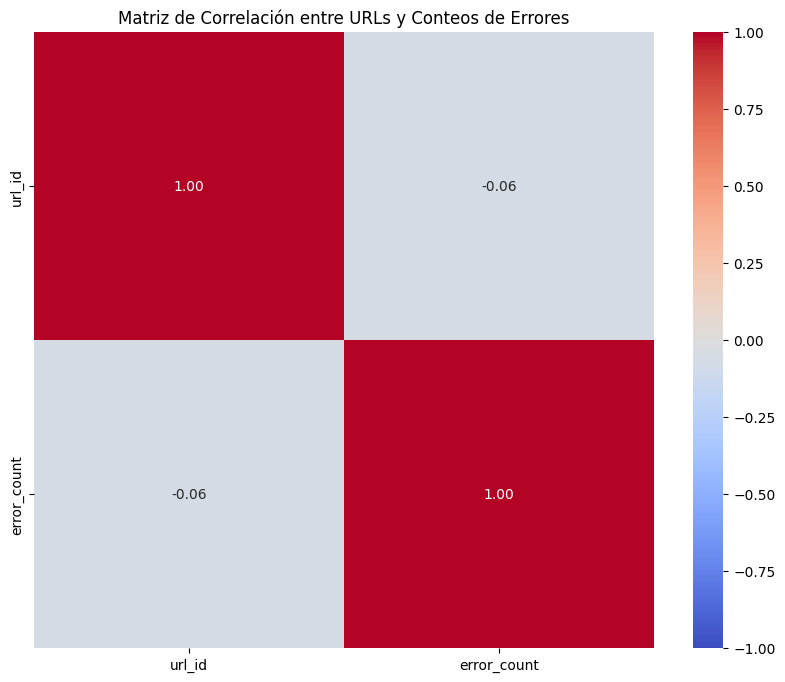

In [46]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_errores = df_limpio.filter(pl.col("status_code").str.contains(r"^4|^5"))
url_error_counts = df_errores.groupby("url").agg(pl.count("status_code").alias("error_count"))

url_encoded = url_error_counts.with_columns(
    pl.col("url").cum_count().alias("url_id")
)
error_frequencies = url_encoded.select(["url_id", "error_count"])
error_frequencies_df = error_frequencies.to_pandas()

correlation_matrix = error_frequencies_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Matriz de Correlación entre URLs y Conteos de Errores')
plt.show()
